In [2]:
import numpy as np 
import pandas as pd 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, yeojohnson
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer, Attention
from keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf 

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/chitoge729/Dataset/main/all_fuels_data_2023.csv")

In [6]:
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)

IQR = Q3 - Q1

LL = Q1 - 1.5*IQR
UL = Q3 + 1.5*IQR

outliers = df[(df['volume']<LL) | (df['volume'])>UL]
df_filtered = df[(df['volume'] >= LL) & (df['volume'] <= UL)]

In [7]:
SC = StandardScaler()

df_1 = df_filtered[['volume', 'open', 'high', 'low', 'close']]
df_2 = SC.fit_transform(df_1)

In [8]:
numeric_columns = df_filtered.select_dtypes(include=['number'])

In [9]:
df_standardized = df_filtered.copy()

In [10]:
df_standardized[numeric_columns.columns] = SC.fit_transform(numeric_columns)

<Axes: xlabel='open', ylabel='Count'>

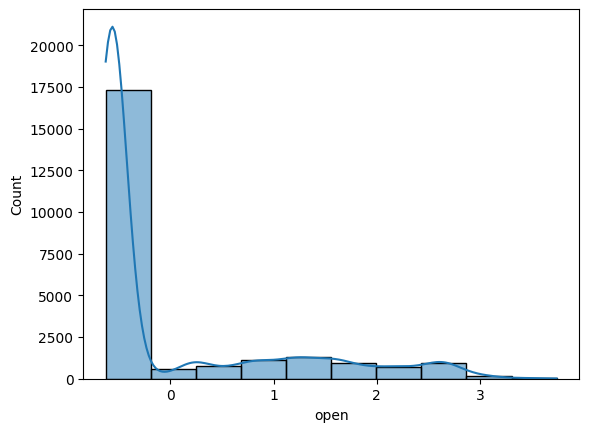

In [11]:
sns.histplot(df_standardized['open'], bins=10, kde=True)

In [12]:
columns_to_transform = ['open', 'high', 'low', 'close', 'volume']

for column in columns_to_transform:
    column_data = df_standardized[column]
    if (column_data > 0).all():
        transformed_data, _ = yeojohnson(column_data)
        df_standardized[column] = transformed_data

<Axes: xlabel='open', ylabel='Count'>

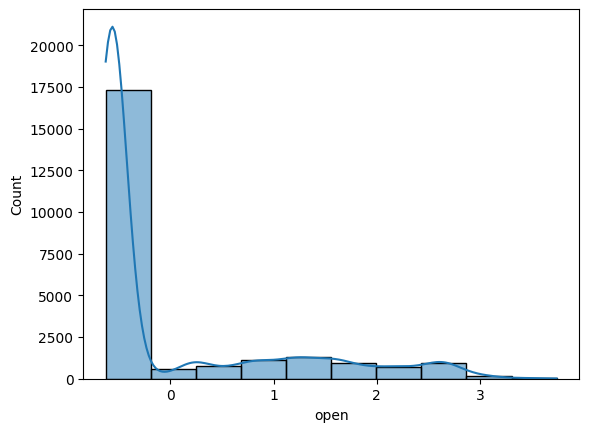

In [13]:
sns.histplot(df_standardized['open'], bins=10, kde=True)

In [14]:
skewness_before = df_standardized[['open', 'high', 'low', 'close', 'volume']].apply(skew)
print("Skewness before transformation:\n", skewness_before)

Skewness before transformation:
 open      1.587568
high      1.582545
low       1.593113
close     1.587781
volume    1.528560
dtype: float64


In [15]:
# Define features to transform
numeric_cols = df_standardized.select_dtypes(include=np.number)
df_features = df_standardized[numeric_cols.columns]

# Use GridSearchCV to find the optimal parameters for PowerTransformer with Yeo-Johnson method
params = {'powertransformer__standardize': [True, False]}
yeo_johnson_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('powertransformer', PowerTransformer())
])
grid_search = GridSearchCV(yeo_johnson_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df_features)
# Get the best parameters
best_params = grid_search.best_estimator_.named_steps['powertransformer'].get_params()
# Remove the 'method' parameter from best_params
best_params.pop('method', None)

# Apply PowerTransformer with the best parameters
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', **best_params)
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(df_features)

# Compute skewness after transformation
skewness_after_yeo_johnson = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns).apply(skew)
print(skewness_after_yeo_johnson)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)

open      0.931701
high      0.929227
low       0.934172
close     0.931924
volume    0.118406
dtype: float64


In [16]:
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(numeric_cols)

# Create a DataFrame with transformed numeric values
df_transformed_numeric = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns, index=numeric_cols.index)

# Concatenate the transformed numeric columns with non-numeric columns
df_transformed = pd.concat([df_standardized[['ticker', 'commodity', 'date']], df_transformed_numeric], axis=1)

# Replace the original numeric columns in df_standardized with transformed values
df_standardized[df_transformed.columns] = df_transformed

<Axes: xlabel='open', ylabel='Count'>

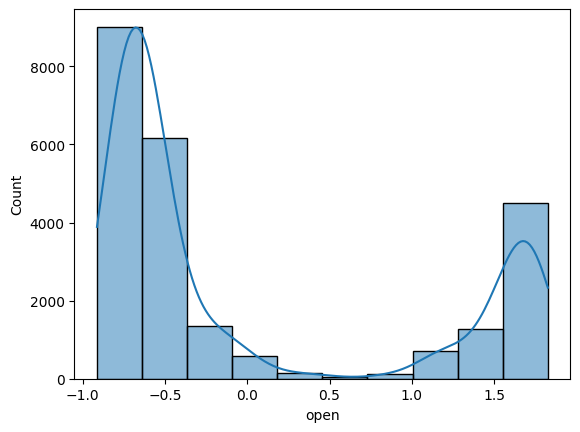

In [17]:
sns.histplot(df_transformed['open'], bins=10, kde=True)

In [18]:
# Define features to transform
numeric_cols = df_transformed.select_dtypes(include=np.number)
df_features = df_transformed[numeric_cols.columns]

# Use GridSearchCV to find the optimal parameters for PowerTransformer with Yeo-Johnson method
params = {'powertransformer__standardize': [True, False]}
yeo_johnson_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('powertransformer', PowerTransformer())
])
grid_search = GridSearchCV(yeo_johnson_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df_features)
# Get the best parameters
best_params = grid_search.best_estimator_.named_steps['powertransformer'].get_params()
# Remove the 'method' parameter from best_params
best_params.pop('method', None)

# Apply PowerTransformer with the best parameters
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', **best_params)
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(df_features)

# Compute skewness after transformation
skewness_after_yeo_johnson = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns).apply(skew)
print(skewness_after_yeo_johnson)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)

open      0.533817
high      0.532170
low       0.535752
close     0.534302
volume   -0.010825
dtype: float64


In [19]:
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(numeric_cols)

# Create a DataFrame with transformed numeric values
df_transformed_numeric = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns, index=numeric_cols.index)

# Concatenate the transformed numeric columns with non-numeric columns
df_transformed1 = pd.concat([df_transformed[['ticker', 'commodity', 'date']], df_transformed_numeric], axis=1)

# Replace the original numeric columns in df_standardized with transformed values
df_transformed[df_transformed1.columns] = df_transformed1

<Axes: xlabel='open', ylabel='Count'>

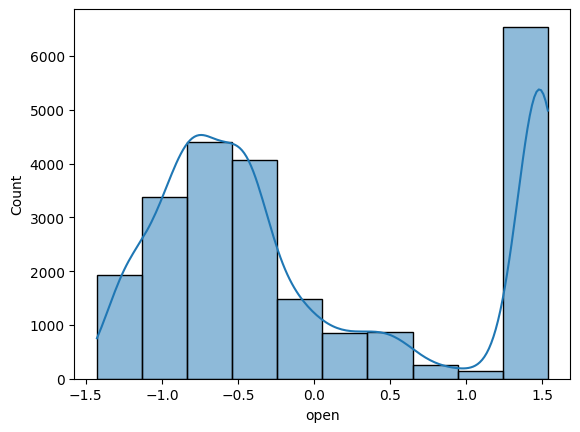

In [20]:
sns.histplot(df_transformed1['open'], bins=10, kde=True)

In [21]:
# Define features to transform
numeric_cols = df_transformed1.select_dtypes(include=np.number)
df_features = df_transformed1[numeric_cols.columns]

# Use GridSearchCV to find the optimal parameters for PowerTransformer with Yeo-Johnson method
params = {'powertransformer__standardize': [True, False]}
yeo_johnson_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('powertransformer', PowerTransformer())
])
grid_search = GridSearchCV(yeo_johnson_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df_features)
# Get the best parameters
best_params = grid_search.best_estimator_.named_steps['powertransformer'].get_params()
# Remove the 'method' parameter from best_params
best_params.pop('method', None)

# Apply PowerTransformer with the best parameters
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', **best_params)
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(df_features)

# Compute skewness after transformation
skewness_after_yeo_johnson = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns).apply(skew)
print(skewness_after_yeo_johnson)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)

open      0.148468
high      0.149847
low       0.147327
close     0.148571
volume   -0.019894
dtype: float64


In [22]:
transformed_data_yeo_johnson = yeo_johnson_transformer.fit_transform(numeric_cols)

# Create a DataFrame with transformed numeric values
df_transformed_numeric = pd.DataFrame(transformed_data_yeo_johnson, columns=numeric_cols.columns, index=numeric_cols.index)

# Concatenate the transformed numeric columns with non-numeric columns
df_transformed2 = pd.concat([df_transformed[['ticker', 'commodity', 'date']], df_transformed_numeric], axis=1)

# Replace the original numeric columns in df_standardized with transformed values
df_transformed1[df_transformed2.columns] = df_transformed2

<Axes: xlabel='open', ylabel='Count'>

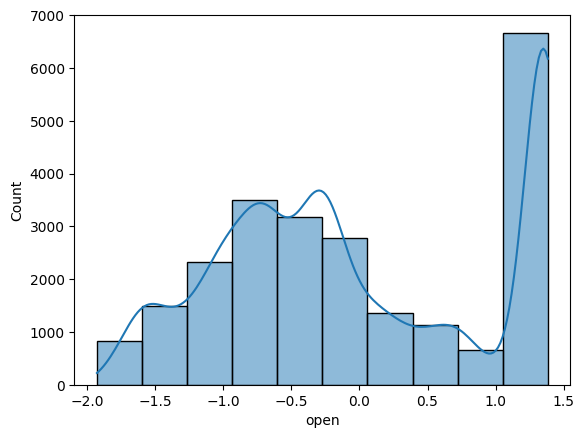

In [23]:
sns.histplot(df_transformed2['open'], bins=10, kde=True)

In [24]:
df_transformed2['date'] = pd.to_datetime(df_transformed2['date'])

df_transformed2['DayOfWeek'] = df_transformed2['date'].dt.dayofweek
df_transformed2['Month'] = df_transformed2['date'].dt.month
df_transformed2['Year'] = df_transformed2['date'].dt.year

In [25]:
label_encoder = LabelEncoder()

df_transformed2['Symbol_encoded'] = label_encoder.fit_transform(df_transformed2['commodity'])

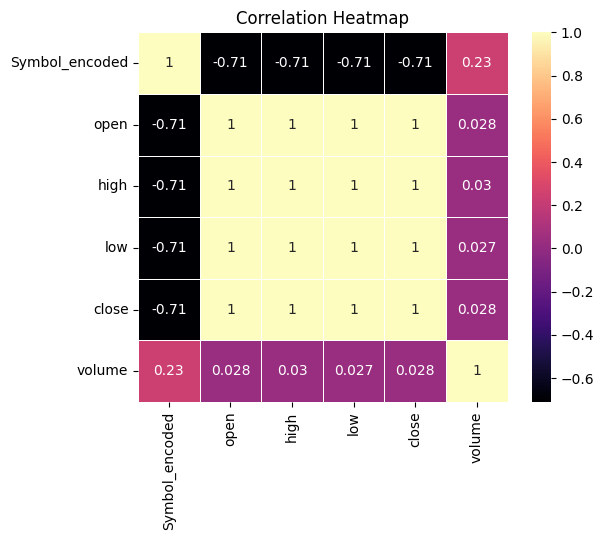

In [26]:
correlation_matrix = df_transformed2[['Symbol_encoded', 'open', 'high', 'low', 'close', 'volume']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='magma', linewidths=0.5, square=True)

plt.title('Correlation Heatmap')
plt.show()

In [37]:
df_transformed2['commodity'].value_counts()

Heating Oil        11766
RBOB Gasoline      11688
Natural Gas        11504
Brent Crude Oil     8204
Crude Oil           5182
Name: commodity, dtype: int64


Epoch 1/50

280/280 [==============================] - 34s 74ms/step - loss: 0.1159 - val_loss: 0.0553
Epoch 2/50
280/280 [==============================] - 19s 69ms/step - loss: 0.0638 - val_loss: 0.0406
Epoch 3/50
280/280 [==============================] - 24s 84ms/step - loss: 0.0566 - val_loss: 0.0262
Epoch 4/50
280/280 [==============================] - 24s 85ms/step - loss: 0.0522 - val_loss: 0.0982
Epoch 5/50
280/280 [==============================] - 24s 85ms/step - loss: 0.0496 - val_loss: 0.0414
Epoch 6/50
280/280 [==============================] - 25s 88ms/step - loss: 0.0480 - val_loss: 0.0247
Epoch 7/50
280/280 [==============================] - 26s 94ms/step - loss: 0.0476 - val_loss: 0.0181
Epoch 8/50
280/280 [==============================] - 21s 75ms/step - loss: 0.0462 - val_loss: 0.0129
Epoch 9/50
280/280 [==============================] - 17s 60ms/step - loss: 0.0452 - val_loss: 0.0288
Epoch 10/50
280/280 [==============================] - 17s 60ms/step - loss: 0.0

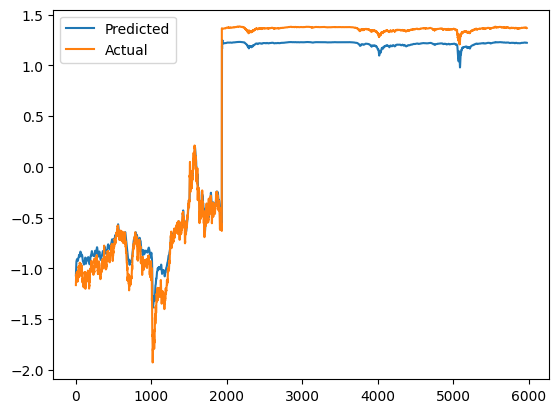

First 10 values of y_test:
[[-1.16480173]
 [-1.11985225]
 [-1.1230027 ]
 [-1.06550115]
 [-1.08260182]
 [-1.0797893 ]
 [-1.09303969]
 [-1.10765052]
 [-1.10288785]
 [-1.09042558]]
First 10 values of predictions:
[[-1.0689832 ]
 [-1.046262  ]
 [-1.0191637 ]
 [-0.99177045]
 [-0.96697754]
 [-0.9503242 ]
 [-0.94318897]
 [-0.93540126]
 [-0.928572  ]
 [-0.92283857]]


In [27]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error  # Import MAE
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined target_variable, target_data, and df_transformed
target_variable = 'open'
# Ensure target_data is a 1D array (flatten if necessary)
target_data = np.array(df_transformed2[target_variable]).reshape(-1, 1)

scaler = MinMaxScaler()
target_data_scaled = scaler.fit_transform(target_data)

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10

sequences = create_sequences(target_data_scaled, sequence_length)

train_size = int(len(sequences) * 0.75)
train_data, test_data = sequences[:train_size], sequences[train_size:]

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Define the Attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def _init_(self, **kwargs):
        super(AttentionLayer, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k)
        v = x
        attn_score = tf.matmul(q, k, transpose_b=True)
        attn_score = tf.nn.softmax(attn_score, axis=-1)
        output = tf.matmul(attn_score, v)
        return output

# Model using the Attention layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(25, activation='relu', return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_absolute_error')  # Use 'mean_absolute_error' as the loss function

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_original_scale, predictions)
print(f'LSTM Mean Absolute Error: {mae}')

plt.plot(predictions, label='Predicted')
plt.plot(y_test_original_scale, label='Actual')
plt.legend()
plt.show()

print("First 10 values of y_test:")
print(y_test_original_scale[:10])

print("First 10 values of predictions:")
print(predictions[:10])

Epoch 1/50
280/280 [==============================] - 34s 70ms/step - loss: 0.0245 - val_loss: 6.7049e-04
Epoch 2/50
280/280 [==============================] - 18s 65ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 3/50
280/280 [==============================] - 18s 64ms/step - loss: 0.0053 - val_loss: 5.8177e-04
Epoch 4/50
280/280 [==============================] - 20s 70ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/50
280/280 [==============================] - 18s 65ms/step - loss: 0.0044 - val_loss: 6.6149e-04
Epoch 6/50
280/280 [==============================] - 19s 68ms/step - loss: 0.0042 - val_loss: 7.2660e-04
Epoch 7/50
280/280 [==============================] - 18s 63ms/step - loss: 0.0358 - val_loss: 0.0020
Epoch 8/50
280/280 [==============================] - 18s 66ms/step - loss: 0.0066 - val_loss: 7.7070e-04
Epoch 9/50
280/280 [==============================] - 18s 65ms/step - loss: 0.0038 - val_loss: 6.5895e-04
Epoch 10/50
280/280 [==============================] - 18s

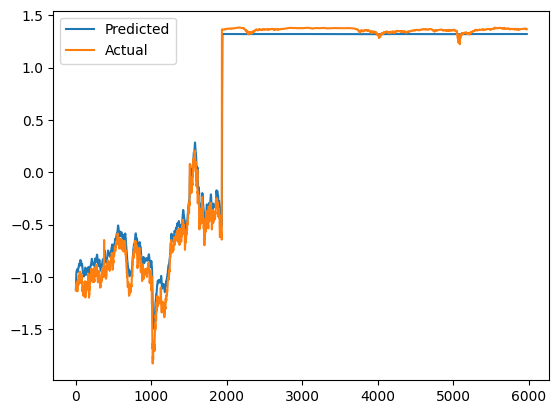

First 10 values of y_test:
[[-1.13117407]
 [-1.11990023]
 [-1.08053996]
 [-1.07495423]
 [-1.08669373]
 [-1.09390661]
 [-1.10756433]
 [-1.10616677]
 [-1.10316512]
 [-1.08918781]]
First 10 values of predictions:
[[-1.1191063 ]
 [-1.0886067 ]
 [-1.0576348 ]
 [-1.0291431 ]
 [-1.0029871 ]
 [-0.97828835]
 [-0.968047  ]
 [-0.9584864 ]
 [-0.9496484 ]
 [-0.94420147]]


In [29]:
# Assuming you have already defined target_variable, target_data, and df_transformed
target_variable = 'high'
# Ensure target_data is a 1D array (flatten if necessary)
target_data = np.array(df_transformed2[target_variable]).reshape(-1, 1)

scaler = MinMaxScaler()
target_data_scaled = scaler.fit_transform(target_data)

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10

sequences = create_sequences(target_data_scaled, sequence_length)

train_size = int(len(sequences) * 0.75)
train_data, test_data = sequences[:train_size], sequences[train_size:]

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Define the Attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def _init_(self, **kwargs):
        super(AttentionLayer, self)._init_(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k)
        v = x
        attn_score = tf.matmul(q, k, transpose_b=True)
        attn_score = tf.nn.softmax(attn_score, axis=-1)
        output = tf.matmul(attn_score, v)
        return output

# Model using the Attention layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(25, activation='relu', return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = AttentionLayer()(x)
x = LSTM(25, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use 'mean_absolute_error' as the loss function

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_original_scale, predictions)
print(f'LSTM Mean Absolute Error: {mse}')

plt.plot(predictions, label='Predicted')
plt.plot(y_test_original_scale, label='Actual')
plt.legend()
plt.show()

print("First 10 values of y_test:")
print(y_test_original_scale[:10])

print("First 10 values of predictions:")
print(predictions[:10])

Epoch 1/10
605/605 [==============================] - 75s 92ms/step - loss: 0.0085 - val_loss: 0.0348
Epoch 2/10
605/605 [==============================] - 52s 86ms/step - loss: 0.0040 - val_loss: 0.0076
Epoch 3/10
605/605 [==============================] - 52s 86ms/step - loss: 0.0033 - val_loss: 0.0127
Epoch 4/10
605/605 [==============================] - 52s 86ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 5/10
605/605 [==============================] - 51s 85ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 6/10
605/605 [==============================] - 52s 86ms/step - loss: 0.0027 - val_loss: 0.0131
Epoch 7/10
605/605 [==============================] - 52s 85ms/step - loss: 0.0026 - val_loss: 9.4233e-04
Epoch 8/10
605/605 [==============================] - 52s 85ms/step - loss: 0.0025 - val_loss: 8.0152e-04
Epoch 9/10
605/605 [==============================] - 52s 86ms/step - loss: 0.0025 - val_loss: 0.0174
Epoch 10/10
303/303 [==============================] - 9s 23ms/step
LSTM M

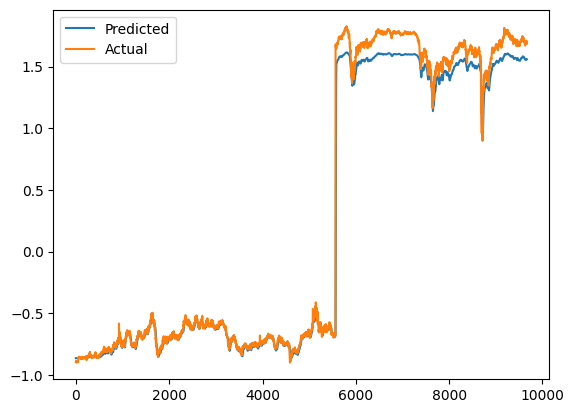

First 10 values of y_test:
[[-0.89752909]
 [-0.89585543]
 [-0.89501894]
 [-0.89669215]
 [-0.89083979]
 [-0.89209295]
 [-0.89042218]
 [-0.89334661]
 [-0.88972629]
 [-0.88805677]]
First 10 values of predictions:
[[-0.86508435]
 [-0.86502105]
 [-0.86500716]
 [-0.86499   ]
 [-0.8649374 ]
 [-0.8649228 ]
 [-0.864885  ]
 [-0.86481744]
 [-0.86479187]
 [-0.8648603 ]]


In [25]:
target_variable = 'high'
target_data = df_transformed[[target_variable]]

scaler = MinMaxScaler()
target_data_scaled = scaler.fit_transform(target_data)

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 20

sequences = create_sequences(target_data_scaled, sequence_length)

train_size = int(len(sequences) * 0.8)
train_data, test_data = sequences[:train_size], sequences[train_size:]

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test, predictions)
print(f'LSTM Mean Squared Error: {mse}')

plt.plot(predictions, label='Predicted')
plt.plot(y_test_original_scale, label='Actual')
plt.legend()
plt.show()

print("First 10 values of y_test:")
print(y_test_original_scale[:10])

print("First 10 values of predictions:")
print(predictions[:10])